In [1]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [11]:
# Get the stock quote
df = yf.download('^GSPC', start = '1970-01-01', end='2021-01-16', progress = False)

In [12]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1970-01-02,92.059998,93.540001,91.790001,93.000000,93.000000,8050000
1970-01-05,93.000000,94.250000,92.529999,93.459999,93.459999,11490000
1970-01-06,93.459999,93.809998,92.129997,92.820000,92.820000,11460000
1970-01-07,92.820000,93.379997,91.930000,92.629997,92.629997,10010000
1970-01-08,92.629997,93.470001,91.989998,92.680000,92.680000,10670000
...,...,...,...,...,...,...
2021-01-11,3803.139893,3817.860107,3789.020020,3799.610107,3799.610107,4450500000
2021-01-12,3801.620117,3810.780029,3776.510010,3801.189941,3801.189941,4977210000
2021-01-13,3802.229980,3820.959961,3791.500000,3809.840088,3809.840088,4590420000


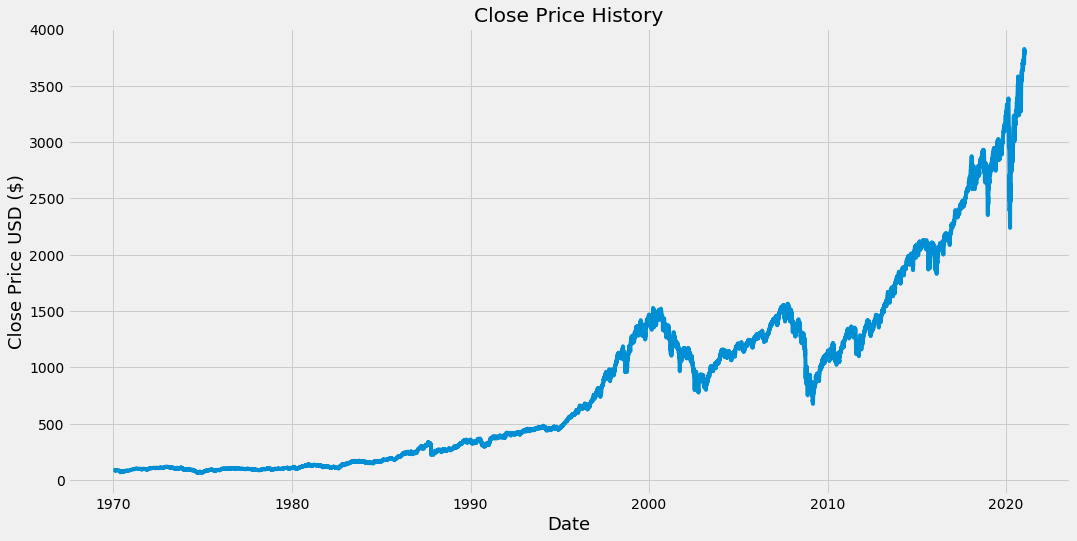

In [13]:
# Visualize closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [14]:
# Create new dataframe with only the 'Close' column
data = df.filter(['Close'])

In [15]:
# Convert dataframe to numpy array
dataset = data.values

In [16]:
# Get the number of rows to train the model on
training_data_len = math.ceil( len(dataset) * 0.8 )

training_data_len

10301

In [17]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

print(len(scaled_data))
scaled_data

12876


array([[0.008165  ],
       [0.00828726],
       [0.00811716],
       ...,
       [0.99605575],
       [0.99225497],
       [0.98500161]])

In [18]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:training_data_len , :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

# Takes the first 60 values for x train and y train is the 61st value
for i in range(60 , len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()

[array([0.008165  , 0.00828726, 0.00811716, 0.00806666, 0.00807995,
       0.00800553, 0.00781948, 0.00787795, 0.00780619, 0.00781416,
       0.00761216, 0.00727461, 0.00732245, 0.00735435, 0.00737827,
       0.00720019, 0.00688125, 0.00673506, 0.00651446, 0.00622209,
       0.00604401, 0.00623804, 0.00650914, 0.00636828, 0.00627791,
       0.0063922 , 0.00657293, 0.00633107, 0.00655433, 0.00649851,
       0.00644801, 0.00642941, 0.00640283, 0.00668722, 0.00677227,
       0.00684404, 0.0068334 , 0.00719488, 0.00707527, 0.00723474,
       0.00729056, 0.00742877, 0.00737827, 0.00736764, 0.0072188 ,
       0.00697161, 0.0070354 , 0.00701946, 0.00692377, 0.00679885,
       0.00654635, 0.00664735, 0.0067138 , 0.00668191, 0.00658622,
       0.00656762, 0.00683075, 0.00730651, 0.00734637, 0.0072693 ])]
[0.007269295918076752]



In [19]:
# Convert x_train and y_train to numpy arrays to train LSTM model
x_train, y_train = np.array(x_train), np.array(y_train)

In [20]:
# Reshape the data because LSTM takes input as 3D and our data is in 2D
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(10241, 60, 1)

In [45]:
# give best model loop
rmse = 10
while rmse > 6:
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(25))
    model.add(Dense(1))
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Train the model
    model.fit(x_train, y_train, batch_size=1, epochs=1)
    # Create the testing data set
    # Create a new array containing scaled values from 552-60 to 765
    test_data = scaled_data[training_data_len - 60: , :]
    # Create the data sets x_test and y_test
    x_test = []
    y_test = dataset[training_data_len:, :]

    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
    # Convert the data to a numpy array
    x_test = np.array(x_test)
    # Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    # Get the models predicted price values
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    rmse = np.sqrt( np.mean( predictions - y_test )**2 )


10241/10241 [==============================] - 169s 16ms/step - loss: 2.8717e-04


### TEST

In [31]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(25))
model.add(Dense(1))

In [32]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [33]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

10241/10241 [==============================] - 159s 15ms/step - loss: 1.7590e-04


In [34]:
# Create the testing data set
# Create a new array containing scaled values from 552-60 to 765
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [35]:
# Convert the data to a numpy array
x_test = np.array(x_test)

In [42]:
# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [37]:
# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [46]:
# Get the root mean squared error (RMSE)
rmse = np.sqrt( np.mean( predictions - y_test )**2 )
rmse

5.026348793992718

### TEST

C:\Users\Sam\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


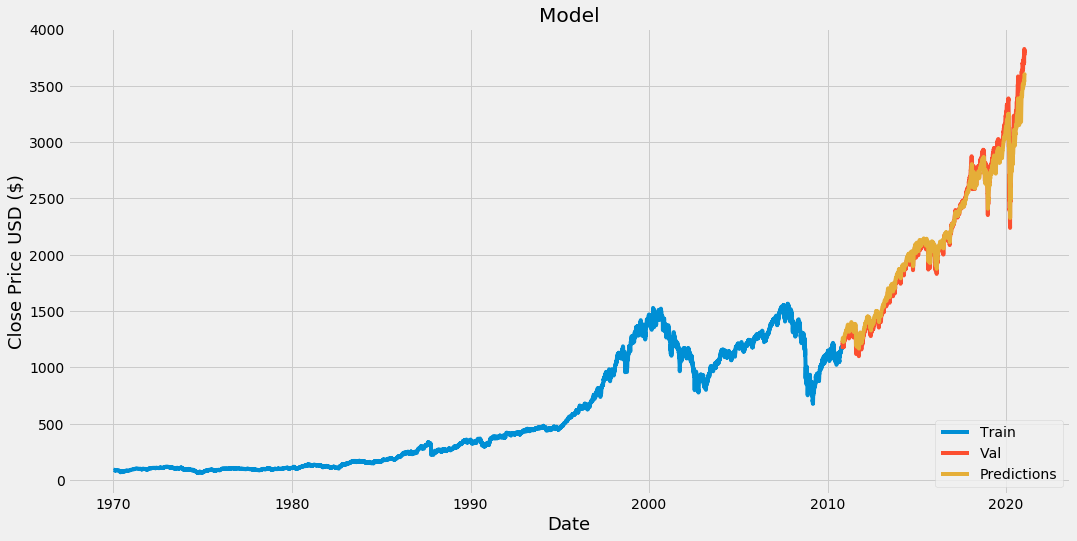

In [47]:
# plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [48]:
# Show the valid and the predicted prices
valid['RMSE'] = (valid['Predictions'] - valid['Close'])**2
valid['Variance %'] = ((valid['Close'] - valid['Predictions'])/valid['Close']) * 100
valid

C:\Users\Sam\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Sam\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Close,Predictions,RMSE,Variance %
Date,,,,
2010-10-25,1185.619995,1220.876953,1243.053088,-2.973715
2010-10-26,1185.640015,1223.707886,1449.162810,-3.210744
2010-10-27,1182.449951,1225.732666,1873.393404,-3.660427
2010-10-28,1183.780029,1225.819214,1767.293039,-3.551267
2010-10-29,1183.260010,1225.772949,1807.350021,-3.592865
...,...,...,...,...
2021-01-11,3799.610107,3591.327393,43381.689303,5.481687
2021-01-12,3801.189941,3598.826904,40950.798788,5.323676
2021-01-13,3809.840088,3599.337891,44311.175054,5.525224


In [41]:
# Get the quote
snp_quote =  

SyntaxError: invalid syntax (<ipython-input-41-3f6af66ba265>, line 2)